In [1]:
import numpy as np
import pandas as pd
import re
import pickle
import itertools
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
import csv


# SK-learn libraries for learning.
#from sklearn.pipeline import Pipeline
#from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# NLTK libs
from nltk.tokenize import TweetTokenizer

# Load Data

In [2]:
## Load combined comments
data_path = "/Users/kwheatley/Desktop/w266_nfl/"
combined_comments = 'Comments_FanofGame_data_bandwagon.csv'

data = pd.read_csv(data_path+combined_comments)
data.head()

,Unnamed: 0,author_flair,submission_title,comment_body,fan_of_team_playing,bandwagon,fan_of_team_playing_w_bandwagon
0,0,Bengals,Game Thread: Detroit Lions (8-6) at Cincinnati...,I love Lions fans cause we can drink bleach to...,1,0,1
1,1,Lions,Game Thread: Detroit Lions (8-6) at Cincinnati...,"I was back and forth with this, but I'm on the...",1,0,1
2,2,Lions,Game Thread: Detroit Lions (8-6) at Cincinnati...,Ebron with that sick Naruto run.,1,0,1
3,3,Lions,Game Thread: Detroit Lions (8-6) at Cincinnati...,"""Here, Merry Christmas. have this win.""\n\n""No...",1,0,1
4,4,Eagles - Bandwagon,Game Thread: Detroit Lions (8-6) at Cincinnati...,The coaching staff does realize that if we los...,0,1,0


In [3]:
# Remove Superbowl threads
# data.submission_title.unique()
data = data[
(data.submission_title!='Super Bowl LII Game Thread: Philadelphia Eagles (15-3) at New England Patriots (15-3)') &
(data.submission_title!='Super Bowl LII Game Thread: Philadelphia Eagles (15-3) at New England Patriots (15-3) (Second Half)') &
(data.submission_title!='Super Bowl 51 Pre Game Thread: New England Patriots (14-2) at Atlanta Falcons (11-5)') &
(data.submission_title!='Super Bowl 51 Post Game Thread: New England Patriots (14-2) at Atlanta Falcons (11-5)') &
(data.submission_title!='Game Thread: Atlanta Falcons (10-6) at Los Angeles Rams (11-5)') &
(data.submission_title!='Game Thread: Tennessee Titans (9-7) at Kansas City Chiefs (10-6)') &
(data.submission_title!='Game Thread: Buffalo Bills (9-7) at Jacksonville Jaguars (10-6)') &
(data.submission_title!='Game Thread: Carolina Panthers (11-5) at New Orleans Saints (11-5)') &
(data.submission_title!='Game Thread: Atlanta Falcons (11-6) at Philadelphia Eagles (13-3)') &
(data.submission_title!='Game Thread: Tennessee Titans (10-7) at New England Patriots (13-3)') &
(data.submission_title!='Game Thread: Jacksonville Jaguars (11-6) at Pittsburgh Steelers (13-3)') &
(data.submission_title!='Game Thread: Jacksonville Jaguars (12-6) at New England Patriots (14-3)') &
(data.submission_title!='Game Thread: Minnesota Vikings (14-3) at Philadelphia Eagles (14-3)') 
]

In [4]:
data.head()

,Unnamed: 0,author_flair,submission_title,comment_body,fan_of_team_playing,bandwagon,fan_of_team_playing_w_bandwagon
0,0,Bengals,Game Thread: Detroit Lions (8-6) at Cincinnati...,I love Lions fans cause we can drink bleach to...,1,0,1
1,1,Lions,Game Thread: Detroit Lions (8-6) at Cincinnati...,"I was back and forth with this, but I'm on the...",1,0,1
2,2,Lions,Game Thread: Detroit Lions (8-6) at Cincinnati...,Ebron with that sick Naruto run.,1,0,1
3,3,Lions,Game Thread: Detroit Lions (8-6) at Cincinnati...,"""Here, Merry Christmas. have this win.""\n\n""No...",1,0,1
4,4,Eagles - Bandwagon,Game Thread: Detroit Lions (8-6) at Cincinnati...,The coaching staff does realize that if we los...,0,1,0


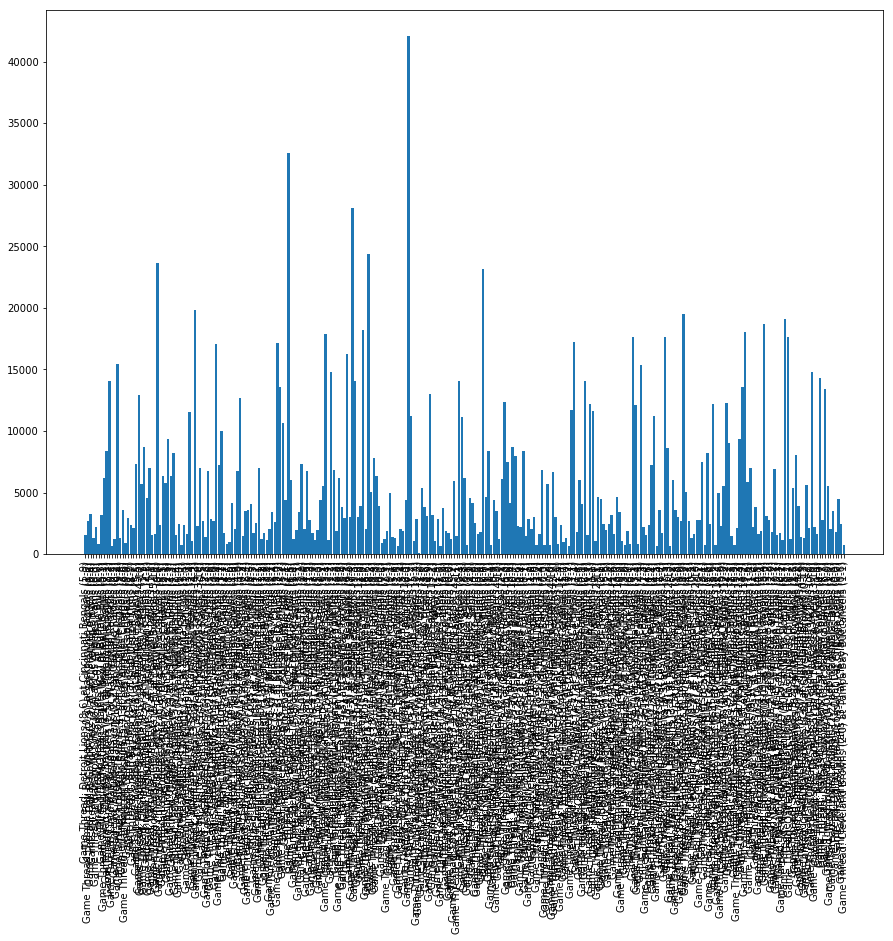

In [5]:
plt.figure(figsize=(15,10))
labels, values = zip(*Counter(data.submission_title).items())

indexes = np.arange(len(labels))
width = .9

plt.bar(indexes, values, width)
plt.xticks(indexes, labels,rotation='vertical')
plt.show()

In [6]:
# Show how many comments are in each thread
pd.DataFrame(data.groupby('submission_title')['comment_body'].count().reset_index())\
.sort_values(by='comment_body',ascending=False).head()

,submission_title,comment_body
133,Game Thread: Kansas City Chiefs (0-0) at New E...,42054
45,Game Thread: Chicago Bears (1-2) at Green Bay ...,32602
222,Game Thread: Philadelphia Eagles (10-1) at Sea...,28137
236,Game Thread: Pittsburgh Steelers (9-2) at Cinc...,24354
226,Game Thread: Philadelphia Eagles (4-1) at Caro...,23617


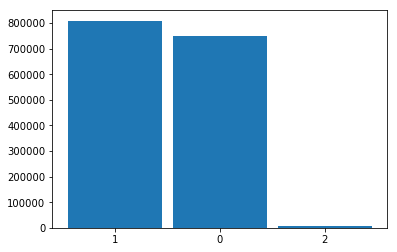

In [7]:
# Show the number of bandwagon fans. Since it is such a small percentage, 
# it's not important to look into.
labels, values = zip(*Counter(data.fan_of_team_playing_w_bandwagon).items())

indexes = np.arange(len(labels))
width = .9

plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()

# Data Preprocessing

In [8]:
# Borrowed some functions from the w266 utils.py file
# Miscellaneous helpers
def flatten(list_of_lists):
    """Flatten a list-of-lists into a single list."""
    return list(itertools.chain.from_iterable(list_of_lists))


# Word processing functions
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=True):
    word = re.sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?\S*", "postedhyperlinkvalue", word)
    word = re.sub(r"(postedhyperlinkvalue)+", "postedhyperlinkvalue", word)
    #if not word.isupper():
    word = word.lower()
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset):
        return word
    else:
        return constants.UNK_TOKEN

def canonicalize_words(words, **kw):
    return [canonicalize_word(word, **kw) for word in words]

In [13]:
def make_data(data, target, tokenizer=TweetTokenizer(), canonize=True):
        
    # Separate comments
    comments = data.loc[:, 'comment_body']
    labels = data.loc[:, target]
    
    # Convert to list
    comment_list = comments.values.tolist()
    
    # Tokenize comments
    tokenizer = tokenizer
    x_tokens = [tokenizer.tokenize(sentence) for sentence in comment_list]

    from nltk.stem import PorterStemmer
    ps = PorterStemmer()

    if canonize:
        comments_canon = []
        for token in x_tokens:
            stem_token = []
            for word in token:
                stem_token.append(ps.stem(word))
            x_tokens_canon = canonicalize_words(stem_token)
            comments_canon.append(x_tokens_canon)
        x_tokens = comments_canon
        
    return comments, x_tokens, labels

In [14]:
# Remove problematic comments

# pd.options.display.max_colwidth = 10000
data = data[data.comment_body.notnull()]
data = data[data.comment_body!='[removed]']
data = data[data.comment_body!='[deleted]']
data = data[~data.comment_body.str.contains("\^This \^message \^was \^created \^by \^a \^bot")]
data = data[~data.comment_body.str.contains("\*\*Please review the rules for")]
data = data[data.notnull()]

data.count()

Unnamed: 0                         1542049
author_flair                       1542049
submission_title                   1542049
comment_body                       1542049
fan_of_team_playing                1542049
bandwagon                          1542049
fan_of_team_playing_w_bandwagon    1542049
fan_binary                         1542049
dtype: int64

In [15]:
data['fan_binary'] = data.fan_of_team_playing.astype(int)

In [16]:
# Remove nofan data
comments, x_tokens, labels = make_data(data, target='fan_binary' )

In [17]:
with open('x_tokens.pickle', 'wb') as handle:
    pickle.dump(x_tokens, handle)
    
with open('labels.pickle', 'wb') as handle:
    pickle.dump(labels, handle)

In [18]:
# Split into test and train
train_data, test_data, train_labels, test_labels = \
    train_test_split(x_tokens, labels, test_size=0.10, random_state=42)  

In [19]:
# Count or TF-IDF vectorize, removing stop words.
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', lowercase=False, 
                             tokenizer=lambda text: text)
                             #tokenizer=lambda text: text, min_df=0.00002, max_df=0.005)

In [29]:
train_data_sparse = vectorizer.fit_transform(train_data)
test_data_sparse = vectorizer.transform(test_data)

/Users/kwheatley/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [21]:
# Save off word counts in csv
flat_list = [item for sublist in x_tokens for item in sublist]
counts = Counter(flat_list)

with open('dict.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in counts.items():
       writer.writerow([key, value])

In [22]:
counts = {}
for label in np.unique(labels):
    counts[label] = sum(labels == label)

print("Class counts:\n{}".format(counts))

Class counts:
{0: 727756, 1: 814293}


In [23]:
727756/(727756+814293)

0.47194090460160476

# Logistic Regression with L1 penalty

In [61]:
# load model
# with open('lasso_classifier.pkl', 'rb') as fid:
#     gnb_loaded = cPickle.load(fid)

In [24]:
test_labels[:10]

609034     1
1102287    1
930455     1
1870879    0
799476     0
351965     1
1256972    1
108314     1
906635     0
687717     1
Name: fan_binary, dtype: int64

In [60]:
lgst_l1 = SGDClassifier(loss="log", penalty="l1",alpha=0.0002)
lgst_l1.fit(train_data_sparse, train_labels)
# save the classifier
with open('lgst_l1_classifier.pkl', 'wb') as fid:
    pickle.dump(lgst_l1, fid)

In [62]:
#Create predictions and evaluate
pred_labels = lgst_l1.predict(test_data_sparse)
print("Training set score: {:.2f}".format(lgst_l1.score(train_data_sparse, train_labels)))
print("Test set score: {:.2f}".format(lgst_l1.score(test_data_sparse, test_labels)))
print("Number of features used: {}".format(np.sum(lgst_l1.coef_ != 0)))

Training set score: 0.54
Test set score: 0.54
Number of features used: 38


In [63]:
lgst_l1.intercept_

array([0.06700174])

In [87]:
n=20
prediction_probs = lgst_l1.predict_proba(test_data_sparse)[:,0]
prob_actual = list(zip(prediction_probs, pred_labels,test_data))

print("Most likely fans")
for row in sorted(prob_actual)[:n]:
    print(row)
print()

print("Least likely fans")
for row in sorted(prob_actual)[-n:]:
    print(row)
print()

Most likely fans
(0.11411545566549197, 1, ["we'r", 'fuck', '.'])
(0.12195469156036287, 1, ["we'r", 'fuck'])
(0.12768077204137096, 1, ['fuck', 'it', "we'r", 'run', 'it', '.'])
(0.1412589943522886, 1, ['no', "we'r", 'not'])
(0.1412589943522886, 1, ['now', "we'r", 'even'])
(0.1412589943522886, 1, ['now', "we'r", 'even'])
(0.1412589943522886, 1, ["we'r", 'back', 'booiiiisss'])
(0.1412589943522886, 1, ["we'r", 'falcon-'])
(0.14413140784819656, 1, ["we'r", 'play', 'stupid', '.', "we'r", 'fuck', 'if', 'we', 'keep', 'thi', 'up', '.'])
(0.15867458656218547, 1, ["we'r", 'back', '!'])
(0.16546558828631308, 1, ["we'r", 'so', 'fuck', 'bad'])
(0.17634576347600472, 1, ["we'r", 'fuck', 'boy', '.'])
(0.18016370026961837, 1, ['touchhdown', '!', "we'r", 'back', 'in', 'thi'])
(0.18551555581873957, 1, ["we'r", 'go', 'for', 'it', '?'])
(0.19420719961575916, 1, ['it', 'is', '3rd', 'down', ',', 'so', "we'r", 'due', '.'])
(0.19892530434643807, 1, ["we'r", 'go', 'to', 'need', 'it'])
(0.2001345769900117, 1, ['no

In [98]:
pd.DataFrame(prob_actual).to_csv("lgst_l1_test_results.csv")

In [90]:
n=50
classifier=lgst_l1

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
for coef, feat in topn_class1:
    print (coef, feat)

print()

for coef, feat in reversed(topn_class2):
    print (coef, feat)

-0.7827721637838269 romo
-0.679945445995341 commerci
-0.6537601617302691 chief
-0.643173563680174 mcadoo
-0.6396304960701477 nfl
-0.5049603867553218 "
-0.5003853371063399 footbal
-0.44428703390797103 watch
-0.30085742445473224 cowboy
-0.2813441127978869 ?
-0.2624596483623222 look
-0.20332020887120478 wow
-0.19592125265405202 holi
-0.1656492055677972 patriot
-0.12315981279229625 like
-0.09883142402323851 game
-0.09787327836972493 lol
-0.05444305531282251 giant
-0.04917452632871937 gruden
0.0 
0.0 
0.0 #
0.0 ###adam
0.0 ###ahh
0.0 ###alert
0.0 ###all
0.0 ###anoth
0.0 ###at
0.0 ###bersin
0.0 ###big
0.0 ###block
0.0 ###brock
0.0 ###bronco
0.0 ###cardiac
0.0 ###cardiac-fucking-cat
0.0 ###cleveland
0.0 ###concret
0.0 ###confirm
0.0 ###crush
0.0 ###cutler
0.0 ###damn
0.0 ###darud
0.0 ###dilli
0.0 ###do
0.0 ###don't
0.0 ###dual
0.0 ###eject
0.0 ###exot
0.0 ###fade
0.0 ###fasteronoffens

1.7378705880941177 we'r
1.0217309156771448 defens
0.8173215887858737 fuck
0.5422002010576393 .
0.483495808

In [ ]:
# lasso = Lasso(alpha=0.0002)
# lasso.fit(train_data, train_labels)

In [ ]:
# #Create predictions and evaluate
# pred_labels = lasso.predict(test_data)
# print("Training set score: {:.2f}".format(lasso.score(train_data, train_labels)))
# print("Test set score: {:.2f}".format(lasso.score(test_data, test_labels)))
# print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

In [ ]:
# n=50
# classifier=lasso

# feature_names = vectorizer.get_feature_names()
    
# topn_class1 = sorted(zip(classifier.coef_, feature_names))[:n]
# topn_class2 = sorted(zip(classifier.coef_, feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (coef, feat)

# print()

# for coef, feat in reversed(topn_class2):
#     print (coef, feat)

# Logistic Regression with L2

In [40]:
# load the model
# with open('lasso_classifier.pkl', 'rb') as fid:
#     gnb_loaded = cPickle.load(fid)

In [92]:
lgst_l2 = SGDClassifier(loss="log", penalty="l2",alpha=5)
lgst_l2.fit(train_data_sparse, train_labels)
with open('lgst_l2_classifier.pkl', 'wb') as fid:
    pickle.dump(lgst_l2, fid)    

In [93]:
#Create predictions and evaluate
pred_labels = lgst_l2.predict(test_data_sparse)
print("Training set score: {:.2f}".format(lgst_l2.score(train_data_sparse, train_labels)))
print("Test set score: {:.2f}".format(lgst_l2.score(test_data_sparse, test_labels)))
#print("Number of features used: {}".format(np.sum(clf.coef_ != 0)))

Training set score: 0.47
Test set score: 0.47


In [94]:
lgst_l2.intercept_

array([-0.00090229])

In [97]:
n=20
prediction_probs = lgst_l2.predict_proba(test_data_sparse)[:,0]
prob_actual = list(zip(prediction_probs, pred_labels,test_data))

print("Most likely fans")
for row in sorted(prob_actual)[:n]:
    print(row)
print()

print("Least likely fans")
for row in sorted(prob_actual)[-n:]:
    print(row)
print()

Most likely fans
(0.5000246533570458, 0, ['go', 'for', 'it', '.', 'go', 'for', 'it', '.', 'go', 'for', 'it', '.', 'fuck', 'go', 'for', 'it'])
(0.5000246533570458, 0, ['what', '.', 'the', '.', 'fuck', '.'])
(0.5000246533570458, 0, ['what', '.', 'the', '.', 'fuck', '.'])
(0.5000246533570458, 0, ['what', '.', 'the', '.', 'fuck', '.'])
(0.5000274346435489, 0, ['fuck', '.', 'me', '.'])
(0.5000274346435489, 0, ['fuck', '.', 'off', '.'])
(0.5000274346435489, 0, ['fuck', '.', 'off', '.'])
(0.5000274346435489, 0, ['fuck', 'it', '.', 'might', 'as', 'well', '.'])
(0.5000274346435489, 0, ['me', 'too', '.', 'what', 'the', 'fuck', '.'])
(0.5000331338618136, 0, ['what', '.', 'the', '.', 'fuck', '.', 'are', '.', 'you', '.', 'do', '.'])
(0.5000442612261777, 0, ['fuck', 'it', ',', 'go', 'for', 'it', '.'])
(0.5000442612261777, 0, ['well', ',', 'fuck', 'me', '.'])
(0.5000444017083461, 0, ['who', '.', 'the', '.', 'fuck', '.', 'are', '.', 'you', '.', 'throw', '.', 'to', '.'])
(0.5000483737191308, 0, ['and',

In [99]:
pd.DataFrame(prob_actual).to_csv("lgst_l2_test_results.csv")

In [100]:
n=50
classifier=lgst_l2

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
for coef, feat in topn_class1:
    print (coef, feat)

print()

for coef, feat in reversed(topn_class2):
    print (coef, feat)

-0.00011760729310810371 "
-6.726679891622285e-05 romo
-6.235112366627682e-05 commerci
-5.529599782273546e-05 nfl
-5.479508697725025e-05 footbal
-5.43575782056008e-05 chief
-5.237695882914267e-05 watch
-5.073535810822589e-05 mcadoo
-4.0157507822937756e-05 cowboy
-3.846001339658458e-05 gruden
-3.71485114874687e-05 wow
-3.669974131425952e-05 patriot
-3.462759272383682e-05 night
-3.231320611704226e-05 raider
-3.1961901518962734e-05 ben
-3.154874572705199e-05 toni
-3.151260932464521e-05 dak
-3.1498844582756355e-05 charger
-3.074965095564171e-05 giant
-3.072247617250401e-05 raven
-2.984721787466866e-05 alex
-2.8629942041943913e-05 dilli
-2.8326623143149334e-05 redskin
-2.710226366286525e-05 dolphin
-2.6922286525188725e-05 bengal
-2.674712029026606e-05 rodger
-2.6534369584321985e-05 espn
-2.638013325438625e-05 collinsworth
-2.6270341858868807e-05 fantasi
-2.6217369497153174e-05 lmao
-2.5361189670275806e-05 tonight
-2.533419198611557e-05 rex
-2.5273348577001648e-05 song
-2.5003446668013355e-05

In [ ]:
# rdg = Ridge(alpha=5)
# rdg.fit(train_data, train_labels)

In [ ]:
# #Create predictions and evaluate
# pred_labels = rdg.predict(test_data)
# print("Training set score: {:.2f}".format(rdg.score(train_data, train_labels)))
# print("Test set score: {:.2f}".format(rdg.score(test_data, test_labels)))
# #print("Number of features used: {}".format(np.sum(clf.coef_ != 0)))

In [ ]:
# n=50
# classifier=rdg

# feature_names = vectorizer.get_feature_names()
    
# topn_class1 = sorted(zip(classifier.coef_, feature_names))[:n]
# topn_class2 = sorted(zip(classifier.coef_, feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (coef, feat)

# print()

# for coef, feat in reversed(topn_class2):
#     print (coef, feat)

# ElasticNet Regression

In [101]:
lgst_elnet = SGDClassifier(loss="log", penalty="elasticnet")
lgst_elnet.fit(train_data_sparse, train_labels)
with open('lgst_elnet_classifier.pkl', 'wb') as fid:
    pickle.dump(lgst_elnet, fid)    

In [102]:
#Create predictions and evaluate
pred_labels = lgst_elnet.predict(test_data_sparse)
print("Training set score: {:.2f}".format(lgst_elnet.score(train_data_sparse, train_labels)))
print("Test set score: {:.2f}".format(lgst_elnet.score(test_data_sparse, test_labels)))
print("Number of features used: {}".format(np.sum(lgst_elnet.coef_ != 0)))

Training set score: 0.58
Test set score: 0.58
Number of features used: 878


In [103]:
lgst_elnet.intercept_

array([0.08065214])

In [105]:
n=20
prediction_probs = lgst_elnet.predict_proba(test_data_sparse)[:,0]
prob_actual = list(zip(prediction_probs, pred_labels,test_data))

print("Most likely fans")
for row in sorted(prob_actual)[:n]:
    print(row)
print()

print("Least likely fans")
for row in sorted(prob_actual)[-n:]:
    print(row)
print()

Most likely fans
(0.10806113654924154, 1, ["we'r", 'fuck', '.'])
(0.11384823229536523, 1, ["we'r", 'fuck'])
(0.11400946382897581, 1, ['fuck', 'it', "we'r", 'run', 'it', '.'])
(0.1323010245515559, 1, ['no', "we'r", 'not'])
(0.1323010245515559, 1, ['now', "we'r", 'even'])
(0.1323010245515559, 1, ['now', "we'r", 'even'])
(0.1323010245515559, 1, ["we'r", 'back', 'booiiiisss'])
(0.1323010245515559, 1, ["we'r", 'falcon-'])
(0.1337699326093127, 1, ["we'r", 'play', 'stupid', '.', "we'r", 'fuck', 'if', 'we', 'keep', 'thi', 'up', '.'])
(0.1354291696978801, 1, ['fuck', ',', "we'r", 'about', 'to', 'get', 'bootyblast', 'with', 'these', 'injuri', 'and', 'our', 'd'])
(0.13775008486633533, 1, ['it', 'is', '3rd', 'down', ',', 'so', "we'r", 'due', '.'])
(0.14706155442817448, 1, ["we'r", 'back', '!'])
(0.1499390105513505, 1, ["we'r", 'fuck', 'boy', '.'])
(0.1510771475915874, 1, ["we'r", 'fuck', 'gg', 'vike'])
(0.15163418178979338, 1, ["we'r", 'so', 'fuck', 'bad'])
(0.160566404766333, 1, ["we'r", 'go', 't

In [106]:
pd.DataFrame(prob_actual).to_csv("lgst_elnet_test_results.csv")

In [104]:
n=50
classifier=lgst_elnet

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
for coef, feat in topn_class1:
    print (coef, feat)

print()

for coef, feat in reversed(topn_class2):
    print (coef, feat)

-1.1136903637166826 chief
-1.1120352844065038 mcadoo
-1.0313378410277256 romo
-0.9718393624705484 commerci
-0.961036290630316 nfl
-0.9480577115016242 gruden
-0.8764876583186363 patriot
-0.8325228864709452 cowboy
-0.8066549124984128 rex
-0.7988282151855567 raven
-0.796227023442498 fantasi
-0.7924398521674934 collinsworth
-0.7903002596236998 charger
-0.7629116622242722 espn
-0.7608788563417069 redskin
-0.7605799406401577 kc
-0.7549954492459807 footbal
-0.7454690196687718 dolphin
-0.7382699496439461 raider
-0.7350644637121259 alex
-0.7107492904268851 bengal
-0.6967429530298563 giant
-0.6893279449177158 song
-0.6821842437092293 dak
-0.679035520801622 night
-0.674861944577279 cutler
-0.6733638385282518 hunt
-0.6692231986351123 toni
-0.6660482551837292 dalton
-0.6442285613280936 watch
-0.6329203124628104 tune
-0.6302662670145164 root
-0.6276940251931168 flacco
-0.6141360378555516 al
-0.6072581374952709 rodger
-0.6063113619032392 bronco
-0.5972678890313661 dalla
-0.5843342849833851 anthem
-0.

In [53]:
test_labels.shape

(154205,)

In [55]:
lgst_elnet.score(test_data, test_labels)

0.5836386628189747

In [ ]:
# elnet = ElasticNet(alpha=0.0001, l1_ratio=0.25)
# elnet.fit(train_data, train_labels)

In [ ]:
# n=50
# classifier=elnet

# feature_names = vectorizer.get_feature_names()
    
# topn_class1 = sorted(zip(classifier.coef_, feature_names))[:n]
# topn_class2 = sorted(zip(classifier.coef_, feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (coef, feat)

# print()

# for coef, feat in reversed(topn_class2):
#     print (coef, feat)

# Logistic Regression

In [56]:
# Train model
lgreg = LogisticRegression()
lgreg.fit(train_data, train_labels)
with open('lgreg_classifier.pkl', 'wb') as fid:
    pickle.dump(lgreg, fid)    

In [57]:
train_labels.sum()
# 1387844
# 732907
732907/1387844

0.5280903329192618

In [58]:
lgreg.intercept_

array([0.22593288])

In [59]:
#Create predictions and evaluate
pred_labels = lgreg.predict(test_data)
acc = metrics.accuracy_score(test_labels, pred_labels)
print("Accuracy on test set: {:.02%}".format(acc))
print('Test Data:')

feature_names = vectorizer.get_feature_names()
# class_labels = lgreg.classes_
# print(class_labels)
# print(classification_report(test_labels, pred_labels, target_names = class_labels, digits=1))
#print(classification_report(test_labels, pred_labels, target_names = ['fan_lose_close', 'fan_lose_notclose', 'fan_win_close', 'fan_win_notclose'], digits=3))

print("Confusion Matrix...")
confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
print(confusionMatrix)

Accuracy on test set: 59.80%
Test Data:
Confusion Matrix...
[[35234 37585]
 [24400 56986]]


In [60]:
n=50
classifier=lgreg

feature_names = vectorizer.get_feature_names()

class_labels = classifier.classes_
topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
for coef, feat in topn_class1:
    print (class_labels[0], coef, feat)

print()

for coef, feat in reversed(topn_class2):
    print (class_labels[1], coef, feat)

0 -2.8081868578853597 mcdonough
0 -2.793369086824292 #eagl
0 -2.63908927623724 DG.DGDGDGDG
0 -2.5981861415942715 england'
0 -2.5247628322177587 tune
0 -2.481086442741055 yahoo
0 -2.4683620972948184 juejueju
0 -2.430910769734393 tony'
0 -2.3901074659472936 jumanji
0 -2.389827740873399 aedeo
0 -2.3860595132062006 rex
0 -2.3660386837216887 kc'
0 -2.321731436515116 skycam
0 -2.3011567117310032 sergio
0 -2.2602700097530883 skatterbug
0 -2.25364360686338 tirico
0 -2.217546437326628 parlay
0 -2.192555378757218 hoki
0 -2.1852735834688644 wembley
0 -2.1134891688478996 gambler
0 -2.1100570398777156 watchespn
0 -2.109977214352655 mallett
0 -2.081419810150383 tyrek
0 -2.0793631685908003 anna
0 -2.0589414275120292 miley
0 -2.0372612687102354 sdsu
0 -2.036846857354331 gruden'
0 -2.0238225971213373 mcadoo
0 -2.0162953451775865 intang
0 -2.014119190017598 cba
0 -2.0092187076457626 heineken
0 -1.9895844994837162 collinsworth
0 -1.9889926073020252 fantasyfootbal
0 -1.9774354311590205 abbi
0 -1.977204808

# Exploration

In [269]:
comments = use_data[use_data.comment_body.notnull()]
comments['comment_body'] = comments.comment_body.map(lambda x: x.lower())
chaz_comments = comments[comments.comment_body.str.contains('ournette')]

In [ ]:
pd.DataFrame(\
comments.groupby(['submission_title','fan_of_team_playing']) \
             ['comment_body'].count().reset_index()).sort_values(by='submission_title',\
                                                                 ascending=False)\
.to_csv("temp.csv")

In [124]:
pd.DataFrame(\
chaz_comments.groupby(['submission_title','fan_of_team_playing']) \
             ['comment_body'].count().reset_index()).sort_values(by='comment_body',\
                                                                 ascending=False)


,submission_title,fan_of_team_playing,comment_body
44,Game Thread: Jacksonville Jaguars (11-6) at Pittsburgh Steelers (13-3),0,932
46,Game Thread: Jacksonville Jaguars (12-6) at New England Patriots (14-3),0,496
45,Game Thread: Jacksonville Jaguars (11-6) at Pittsburgh Steelers (13-3),1,149
9,Game Thread: Buffalo Bills (9-7) at Jacksonville Jaguars (10-6),0,130
6,Game Thread: Baltimore Ravens (2-0) at Jacksonville Jaguars (1-1),0,81
47,Game Thread: Jacksonville Jaguars (12-6) at New England Patriots (14-3),1,74
37,Game Thread: Jacksonville Jaguars (0-0) at Houston Texans (0-0),1,73
51,Game Thread: Jacksonville Jaguars (2-2) at Pittsburgh Steelers (3-1),1,43
36,Game Thread: Jacksonville Jaguars (0-0) at Houston Texans (0-0),0,37
50,Game Thread: Jacksonville Jaguars (2-2) at Pittsburgh Steelers (3-1),0,33


In [250]:
pd.options.display.max_colwidth = 1000
comments = use_data[use_data.comment_body.notnull()]
comments['comment_body'] = comments.comment_body.map(lambda x: x.lower())
chaz_comments = comments[comments.comment_body.str.contains('haley')]
chaz_comments.groupby(['fan_of_team_playing','fan_binary']).count()


,,Unnamed: 0,author_flair,submission_title,comment_body,bandwagon,fan_of_team_playing_w_bandwagon
fan_of_team_playing,fan_binary,,,,,,
0,0,181,181,181,181,181,181
1,1,788,788,788,788,788,788


In [254]:
chaz_comments

,Unnamed: 0,author_flair,submission_title,comment_body,fan_of_team_playing,bandwagon,fan_of_team_playing_w_bandwagon,fan_binary
70831,70831,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),haley: *barely runs the ball at all in the first half*\n\nhaley: *calls 4 rush plays in a row*\n\nthis man can find no balance in his life.,1,0,1,1
70976,70976,Patriots,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),"""in 2006, haley filed a 1.5 million-dollar lawsuit against mcdonald's after his wife found a dead rat in her salad.""\n\nfrom todd haley's wikipedia. honestly, i'm not surprised.",0,0,0,0
71230,71230,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),todd haley seems to have forgotten that play action is an option,1,0,1,1
72969,72969,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),haley called decent plays last week so expect us to throw 50% screens and 3rd and 1 deep balls all game,1,0,1,1
73595,73595,Seahawks,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),todd haley seems like a fun guy lol,0,0,0,0
73605,73605,Vikings,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),todd haley probably slams 3 whiskeys at halftime every week to maintain his image.,0,0,0,0
73999,73999,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),"who's ready for haley to take this momentum and call run, run, pass?",1,0,1,1
74890,74890,no value,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),only todd haley could ruin an offense this stacked with talent,0,0,0,0
75066,75066,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),todd haley loves the delayed handoff on first and 10 for a loss of yardage!!!!!!!!!!!!,1,0,1,1
76761,76761,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),not jinxing it but we haven't seen a todd haley bomb(tm) yet,1,0,1,1


In [253]:
pd.DataFrame(chaz_comments.groupby(['submission_title','fan_binary'])\
             ['comment_body'].count().reset_index())

,submission_title,fan_binary,comment_body
0,Game Thread: Atlanta Falcons (0-1) at Pittsburgh Steelers (1-0),1,4
1,Game Thread: Atlanta Falcons (3-2) at New England Patriots (4-2),0,1
2,Game Thread: Atlanta Falcons (5-4) at Seattle Seahawks (6-3),0,1
3,Game Thread: Atlanta Falcons (5-4) at Seattle Seahawks (6-3),1,1
4,Game Thread: Atlanta Falcons (9-5) at New Orleans Saints (10-4),1,1
5,Game Thread: Baltimore Ravens (2-0) at Jacksonville Jaguars (1-1),0,1
6,Game Thread: Baltimore Ravens (7-5) at Pittsburgh Steelers (10-2),0,5
7,Game Thread: Baltimore Ravens (7-5) at Pittsburgh Steelers (10-2),1,44
8,Game Thread: Buffalo Bills (8-6) at New England Patriots (11-3),0,3
9,Game Thread: Chicago Bears (1-1) at Tennessee Titans (1-1),1,1


In [175]:
percent_chart = pd.read_csv("percent_chart.csv")
percent_chart = percent_chart.sort_values(by='sort_index')
percent_chart = percent_chart.reset_index()

In [176]:
percent_chart.head()

,index,submission_title,not_fan,fan,total_comments,percent_not_fan,percent_not_fans,date,sort_index
0,0,Game Thread: Arizona Cardinals (0-0) at Dallas Cowboys (0-0),4129,1336,5465,0.755535,50-75%,8/3/17,1
1,1,Game Thread: Houston Texans (0-0) at Carolina Panthers (0-0),3400,2043,5443,0.624656,50-75%,8/9/17,2
2,2,Game Thread: Denver Broncos (0-0) at Chicago Bears (0-0),1266,1609,2875,0.440348,25-50%,8/10/17,3
3,3,Game Thread: Jacksonville Jaguars (0-0) at New England Patriots (0-0),143,925,1068,0.133895,0-25%,8/10/17,4
4,4,Game Thread: Minnesota Vikings (0-0) at Buffalo Bills (0-0),272,794,1066,0.255159,0-25%,8/10/17,5


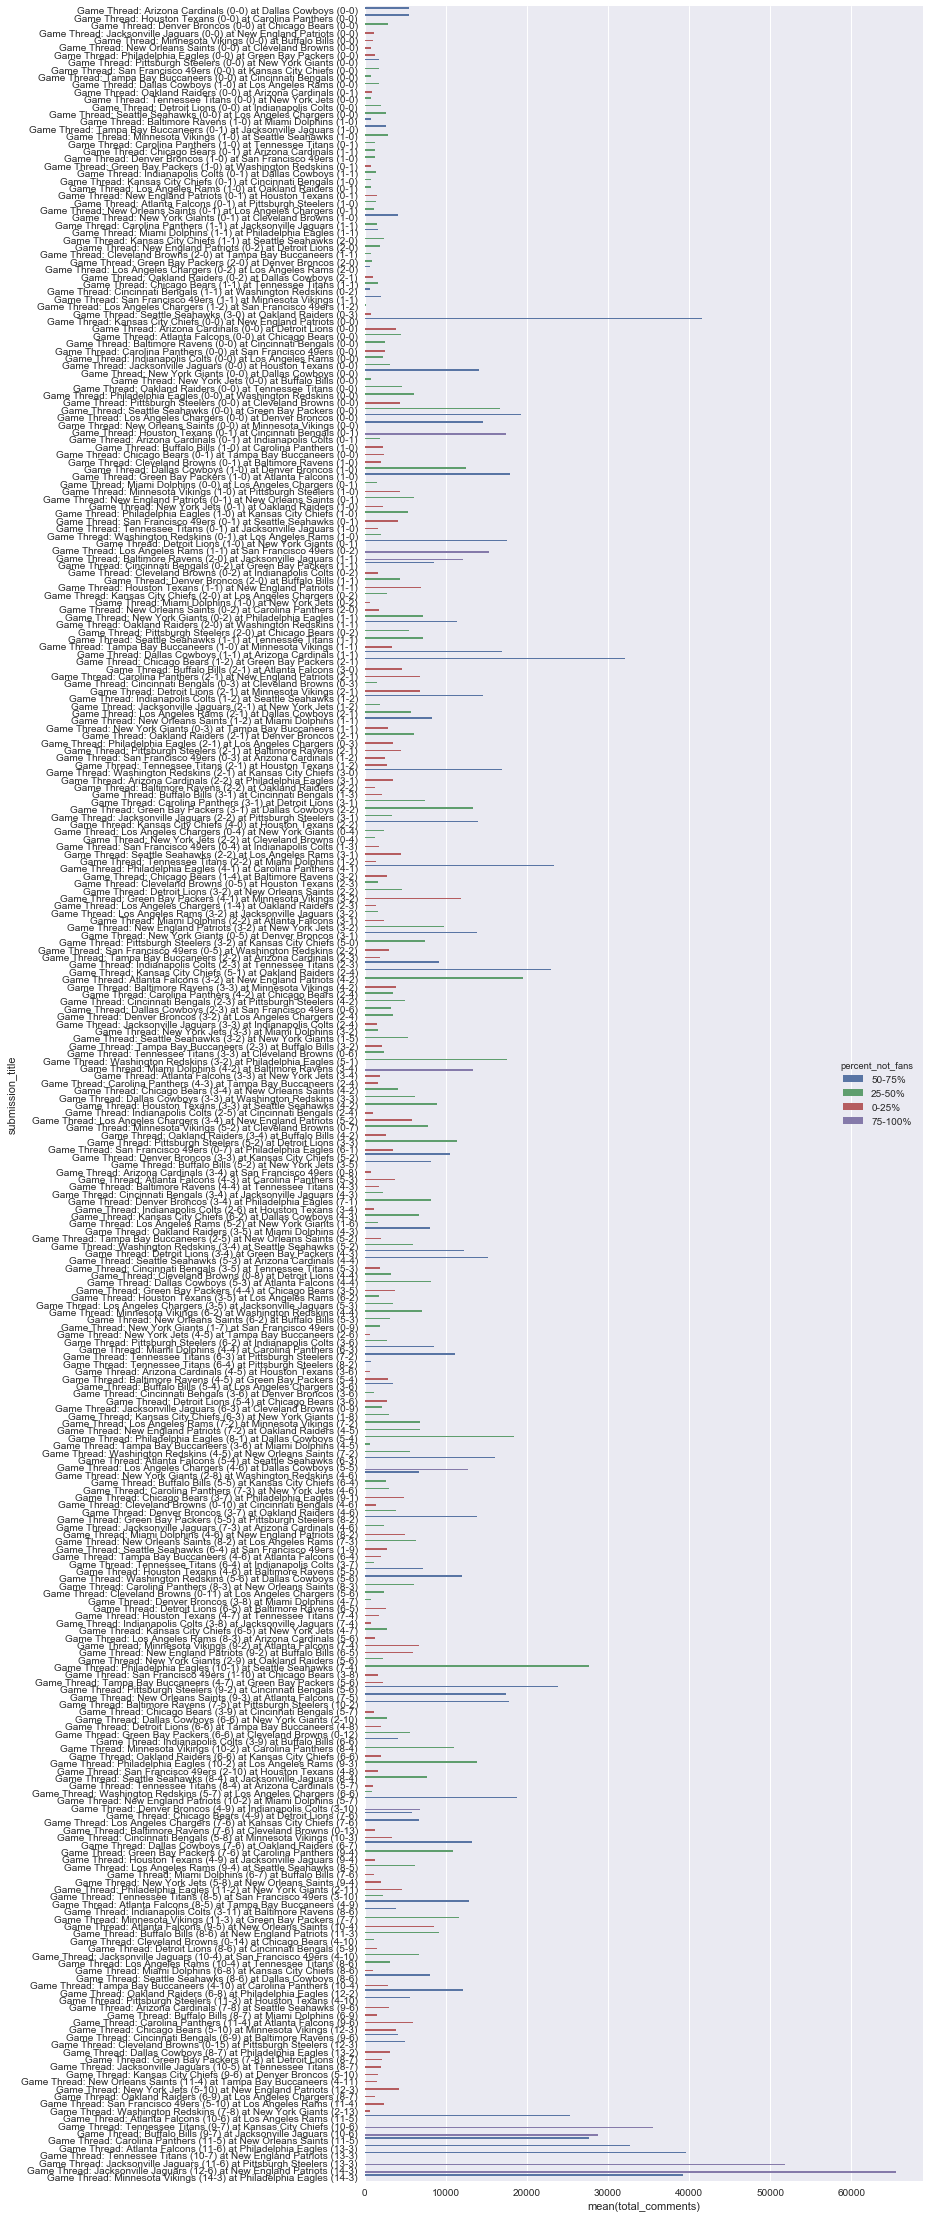

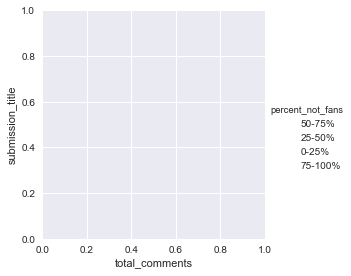

In [178]:
import seaborn
import pandas as pd

fig, ax = plt.subplots()
fig.set_size_inches(10, 40)

seaborn.factorplot(orient='h', ax=ax, y='submission_title', x='total_comments', \
                   hue='percent_not_fans', kind='bar', data=percent_chart )
plt.show()